In [129]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU, BatchNormalization, LeakyReLU
from keras.losses import mse
from keras.constraints import non_neg

In [130]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [131]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [132]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [133]:
runs = [304125,304508,302263]

with open('pileupInput_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
with open('pileupInput_bad.pickle', 'rb') as handle:
    bad_data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

x_bad1 = np.array(bad_data['301480']['samples'])
x_bad2 = np.array(bad_data['305588']['samples'])



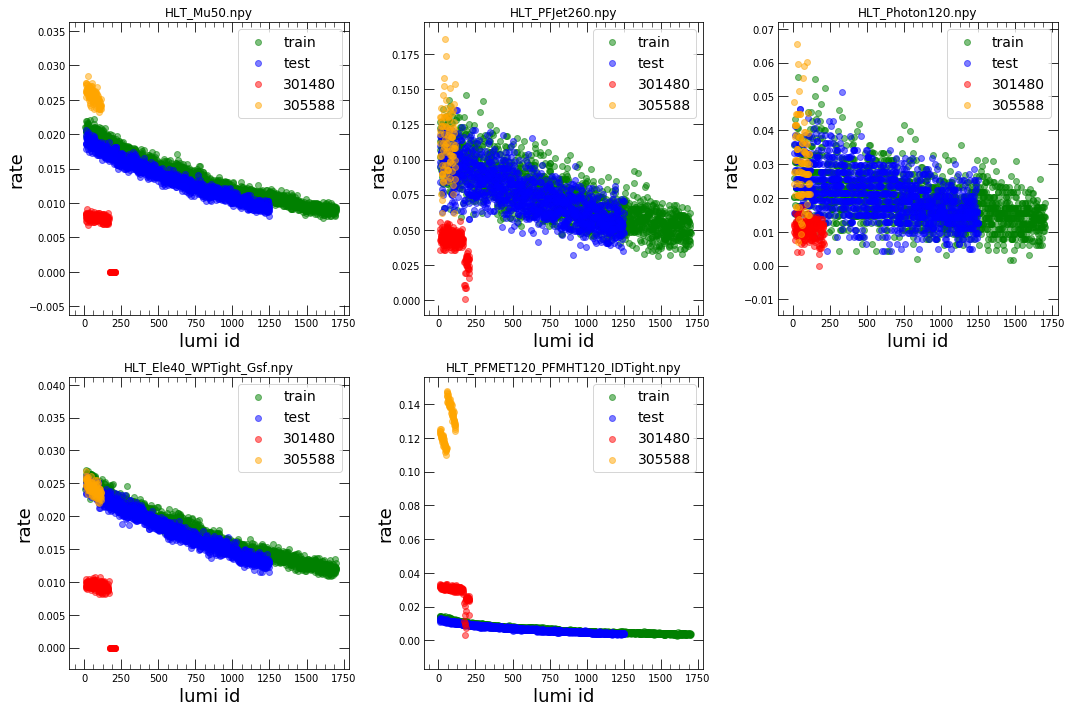

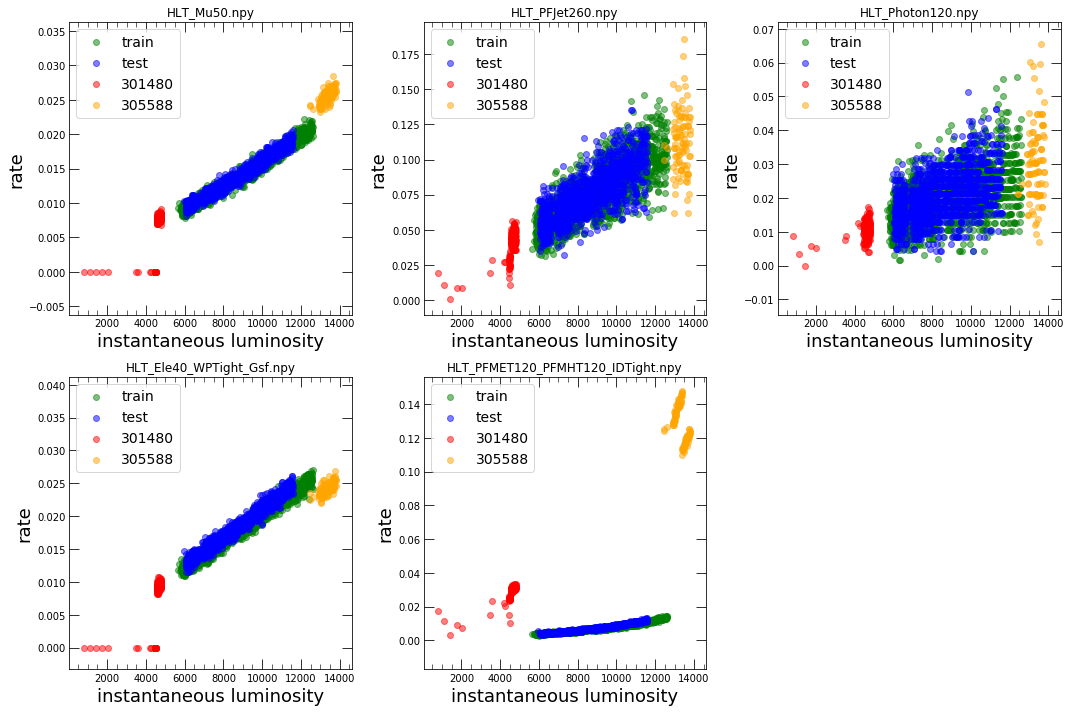

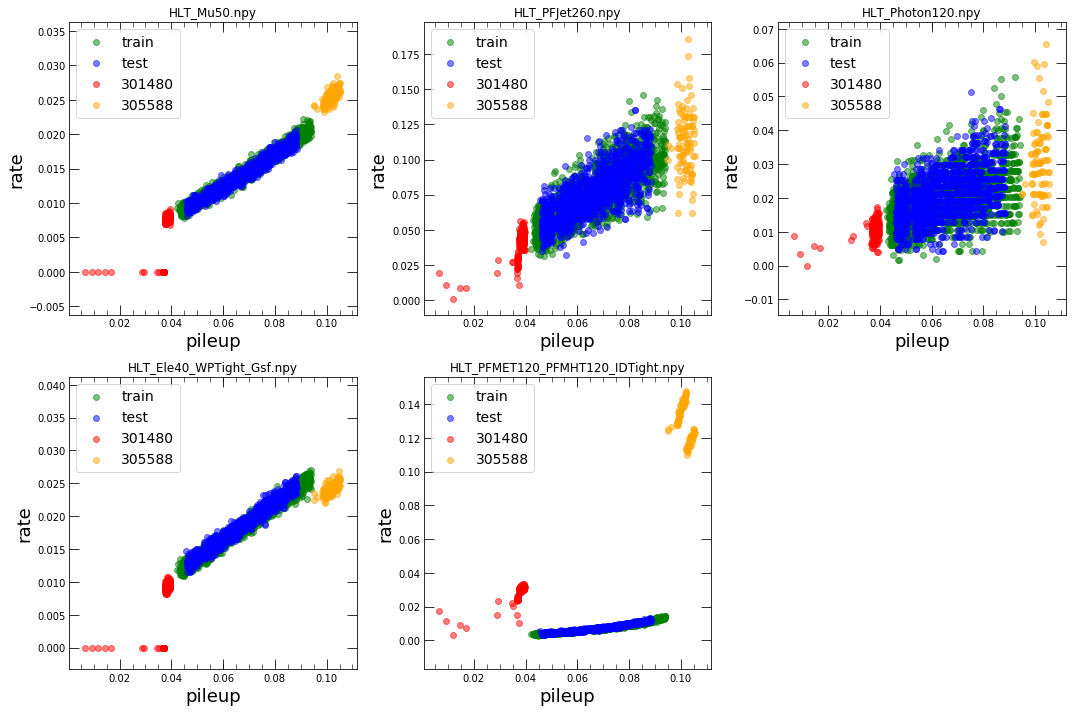

In [134]:
plots = [x_train,x_test,x_bad1,x_bad2]
titles = ["train","test","301480","305588"]

stuff = [[],[],[],[]]
lumi = [[],[],[],[]]
inst = [[],[],[],[]]
pileup = [[],[],[],[]]
for h in range(4):
    if h == 0 or h == 1:
        lumi[h] = data[str(runs[h])]['lumiid']
        inst[h] = data[str(runs[h])]['instlumi']
        pileup[h] = data[str(runs[h])]['pileup']
        stuff[h] = data[str(runs[h])]['rates']
    elif h == 2:
        lumi[h] = bad_data["301480"]['lumiid']
        inst[h] = bad_data["301480"]['instlumi']
        pileup[h] = bad_data["301480"]['pileup']
        stuff[h] = bad_data["301480"]['rates']
    else:
        lumi[h] = bad_data["305588"]['lumiid']
        inst[h] = bad_data["305588"]['instlumi']
        pileup[h] = bad_data["305588"]['pileup']
        stuff[h] = bad_data["305588"]['rates']
    
labels = data['HLT'] 
colors = ["g","b","r","orange"]
    
plt.figure(figsize=[15,10])
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(i[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(inst[k][i]),len(stuff[k][i]))
        plt.scatter(inst[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('instantaneous luminosity')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(pileup[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Simple Autoencoder

In [135]:
model_name = "pileupInputLinear"

In [136]:
# Define the architecture

_input = Input(shape=(6,), name="input")

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation = None,
               name="encoded")(_input)

output = Dense(6,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(hidden)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
encoded (Dense)              (None, 3)                 21        
_________________________________________________________________
reconstructed (Dense)        (None, 6)                 24        
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


Train on 1669 samples, validate on 1224 samples
Epoch 1/1000
 - 2s - loss: 0.3209 - val_loss: 0.3189
Epoch 2/1000
 - 0s - loss: 0.3129 - val_loss: 0.3111
Epoch 3/1000
 - 0s - loss: 0.3052 - val_loss: 0.3033
Epoch 4/1000
 - 0s - loss: 0.2976 - val_loss: 0.2957
Epoch 5/1000
 - 0s - loss: 0.2900 - val_loss: 0.2881
Epoch 6/1000
 - 0s - loss: 0.2826 - val_loss: 0.2807
Epoch 7/1000
 - 0s - loss: 0.2754 - val_loss: 0.2735
Epoch 8/1000
 - 0s - loss: 0.2683 - val_loss: 0.2664
Epoch 9/1000
 - 0s - loss: 0.2613 - val_loss: 0.2595
Epoch 10/1000
 - 0s - loss: 0.2545 - val_loss: 0.2528
Epoch 11/1000
 - 0s - loss: 0.2479 - val_loss: 0.2462
Epoch 12/1000
 - 0s - loss: 0.2415 - val_loss: 0.2398
Epoch 13/1000
 - 0s - loss: 0.2352 - val_loss: 0.2335
Epoch 14/1000
 - 0s - loss: 0.2290 - val_loss: 0.2274
Epoch 15/1000
 - 0s - loss: 0.2230 - val_loss: 0.2215
Epoch 16/1000
 - 0s - loss: 0.2172 - val_loss: 0.2157
Epoch 17/1000
 - 0s - loss: 0.2115 - val_loss: 0.2101
Epoch 18/1000
 - 0s - loss: 0.2061 - val_lo

Epoch 152/1000
 - 0s - loss: 0.0135 - val_loss: 0.0135
Epoch 153/1000
 - 0s - loss: 0.0133 - val_loss: 0.0133
Epoch 154/1000
 - 0s - loss: 0.0131 - val_loss: 0.0131
Epoch 155/1000
 - 0s - loss: 0.0129 - val_loss: 0.0129
Epoch 156/1000
 - 0s - loss: 0.0127 - val_loss: 0.0127
Epoch 157/1000
 - 0s - loss: 0.0125 - val_loss: 0.0125
Epoch 158/1000
 - 0s - loss: 0.0123 - val_loss: 0.0123
Epoch 159/1000
 - 0s - loss: 0.0121 - val_loss: 0.0121
Epoch 160/1000
 - 0s - loss: 0.0119 - val_loss: 0.0120
Epoch 161/1000
 - 0s - loss: 0.0118 - val_loss: 0.0118
Epoch 162/1000
 - 0s - loss: 0.0116 - val_loss: 0.0116
Epoch 163/1000
 - 0s - loss: 0.0114 - val_loss: 0.0114
Epoch 164/1000
 - 0s - loss: 0.0112 - val_loss: 0.0113
Epoch 165/1000
 - 0s - loss: 0.0111 - val_loss: 0.0111
Epoch 166/1000
 - 0s - loss: 0.0109 - val_loss: 0.0109
Epoch 167/1000
 - 0s - loss: 0.0108 - val_loss: 0.0108
Epoch 168/1000
 - 0s - loss: 0.0106 - val_loss: 0.0106
Epoch 169/1000
 - 0s - loss: 0.0104 - val_loss: 0.0105
Epoch 170/

Epoch 301/1000
 - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 302/1000
 - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 303/1000
 - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 304/1000
 - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 305/1000
 - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 306/1000
 - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 307/1000
 - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 308/1000
 - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 309/1000
 - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 310/1000
 - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 311/1000
 - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 312/1000
 - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 313/1000
 - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 314/1000
 - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 315/1000
 - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 316/1000
 - 0s - loss: 0.0017 - val_loss: 0.0018
Epoch 317/1000
 - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 318/1000
 - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 319/

Epoch 441/1000
 - 0s - loss: 5.8430e-04 - val_loss: 5.8238e-04
Epoch 442/1000
 - 0s - loss: 5.7985e-04 - val_loss: 5.7789e-04
Epoch 443/1000
 - 0s - loss: 5.7539e-04 - val_loss: 5.7346e-04
Epoch 444/1000
 - 0s - loss: 5.7102e-04 - val_loss: 5.6906e-04
Epoch 445/1000
 - 0s - loss: 5.6668e-04 - val_loss: 5.6470e-04
Epoch 446/1000
 - 0s - loss: 5.6238e-04 - val_loss: 5.6038e-04
Epoch 447/1000
 - 0s - loss: 5.5813e-04 - val_loss: 5.5610e-04
Epoch 448/1000
 - 0s - loss: 5.5389e-04 - val_loss: 5.5186e-04
Epoch 449/1000
 - 0s - loss: 5.4971e-04 - val_loss: 5.4766e-04
Epoch 450/1000
 - 0s - loss: 5.4558e-04 - val_loss: 5.4350e-04
Epoch 451/1000
 - 0s - loss: 5.4144e-04 - val_loss: 5.3938e-04
Epoch 452/1000
 - 0s - loss: 5.3739e-04 - val_loss: 5.3529e-04
Epoch 453/1000
 - 0s - loss: 5.3334e-04 - val_loss: 5.3125e-04
Epoch 454/1000
 - 0s - loss: 5.2933e-04 - val_loss: 5.2723e-04
Epoch 455/1000
 - 0s - loss: 5.2539e-04 - val_loss: 5.2325e-04
Epoch 456/1000
 - 0s - loss: 5.2144e-04 - val_loss: 5.1

Epoch 572/1000
 - 0s - loss: 2.3094e-04 - val_loss: 2.2831e-04
Epoch 573/1000
 - 0s - loss: 2.2941e-04 - val_loss: 2.2678e-04
Epoch 574/1000
 - 0s - loss: 2.2789e-04 - val_loss: 2.2526e-04
Epoch 575/1000
 - 0s - loss: 2.2638e-04 - val_loss: 2.2375e-04
Epoch 576/1000
 - 0s - loss: 2.2488e-04 - val_loss: 2.2225e-04
Epoch 577/1000
 - 0s - loss: 2.2339e-04 - val_loss: 2.2077e-04
Epoch 578/1000
 - 0s - loss: 2.2192e-04 - val_loss: 2.1930e-04
Epoch 579/1000
 - 0s - loss: 2.2045e-04 - val_loss: 2.1783e-04
Epoch 580/1000
 - 0s - loss: 2.1899e-04 - val_loss: 2.1638e-04
Epoch 581/1000
 - 0s - loss: 2.1756e-04 - val_loss: 2.1494e-04
Epoch 582/1000
 - 0s - loss: 2.1612e-04 - val_loss: 2.1351e-04
Epoch 583/1000
 - 0s - loss: 2.1470e-04 - val_loss: 2.1209e-04
Epoch 584/1000
 - 0s - loss: 2.1329e-04 - val_loss: 2.1069e-04
Epoch 585/1000
 - 0s - loss: 2.1189e-04 - val_loss: 2.0929e-04
Epoch 586/1000
 - 0s - loss: 2.1050e-04 - val_loss: 2.0790e-04
Epoch 587/1000
 - 0s - loss: 2.0912e-04 - val_loss: 2.0

Epoch 703/1000
 - 0s - loss: 1.0186e-04 - val_loss: 9.9566e-05
Epoch 704/1000
 - 0s - loss: 1.0127e-04 - val_loss: 9.8982e-05
Epoch 705/1000
 - 0s - loss: 1.0068e-04 - val_loss: 9.8402e-05
Epoch 706/1000
 - 0s - loss: 1.0010e-04 - val_loss: 9.7826e-05
Epoch 707/1000
 - 0s - loss: 9.9531e-05 - val_loss: 9.7253e-05
Epoch 708/1000
 - 0s - loss: 9.8961e-05 - val_loss: 9.6684e-05
Epoch 709/1000
 - 0s - loss: 9.8390e-05 - val_loss: 9.6120e-05
Epoch 710/1000
 - 0s - loss: 9.7826e-05 - val_loss: 9.5560e-05
Epoch 711/1000
 - 0s - loss: 9.7269e-05 - val_loss: 9.5004e-05
Epoch 712/1000
 - 0s - loss: 9.6716e-05 - val_loss: 9.4452e-05
Epoch 713/1000
 - 0s - loss: 9.6160e-05 - val_loss: 9.3904e-05
Epoch 714/1000
 - 0s - loss: 9.5613e-05 - val_loss: 9.3360e-05
Epoch 715/1000
 - 0s - loss: 9.5072e-05 - val_loss: 9.2819e-05
Epoch 716/1000
 - 0s - loss: 9.4533e-05 - val_loss: 9.2282e-05
Epoch 717/1000
 - 0s - loss: 9.3995e-05 - val_loss: 9.1749e-05
Epoch 718/1000
 - 0s - loss: 9.3465e-05 - val_loss: 9.1

Epoch 834/1000
 - 0s - loss: 5.1750e-05 - val_loss: 4.9853e-05
Epoch 835/1000
 - 0s - loss: 5.1520e-05 - val_loss: 4.9626e-05
Epoch 836/1000
 - 0s - loss: 5.1291e-05 - val_loss: 4.9401e-05
Epoch 837/1000
 - 0s - loss: 5.1065e-05 - val_loss: 4.9177e-05
Epoch 838/1000
 - 0s - loss: 5.0840e-05 - val_loss: 4.8955e-05
Epoch 839/1000
 - 0s - loss: 5.0617e-05 - val_loss: 4.8734e-05
Epoch 840/1000
 - 0s - loss: 5.0394e-05 - val_loss: 4.8515e-05
Epoch 841/1000
 - 0s - loss: 5.0175e-05 - val_loss: 4.8298e-05
Epoch 842/1000
 - 0s - loss: 4.9956e-05 - val_loss: 4.8082e-05
Epoch 843/1000
 - 0s - loss: 4.9740e-05 - val_loss: 4.7867e-05
Epoch 844/1000
 - 0s - loss: 4.9524e-05 - val_loss: 4.7655e-05
Epoch 845/1000
 - 0s - loss: 4.9310e-05 - val_loss: 4.7443e-05
Epoch 846/1000
 - 0s - loss: 4.9097e-05 - val_loss: 4.7234e-05
Epoch 847/1000
 - 0s - loss: 4.8886e-05 - val_loss: 4.7025e-05
Epoch 848/1000
 - 0s - loss: 4.8677e-05 - val_loss: 4.6819e-05
Epoch 849/1000
 - 0s - loss: 4.8469e-05 - val_loss: 4.6

 - 0s - loss: 3.2378e-05 - val_loss: 3.0821e-05
Epoch 965/1000
 - 0s - loss: 3.2290e-05 - val_loss: 3.0735e-05
Epoch 966/1000
 - 0s - loss: 3.2202e-05 - val_loss: 3.0650e-05
Epoch 967/1000
 - 0s - loss: 3.2115e-05 - val_loss: 3.0565e-05
Epoch 968/1000
 - 0s - loss: 3.2028e-05 - val_loss: 3.0481e-05
Epoch 969/1000
 - 0s - loss: 3.1942e-05 - val_loss: 3.0397e-05
Epoch 970/1000
 - 0s - loss: 3.1857e-05 - val_loss: 3.0314e-05
Epoch 971/1000
 - 0s - loss: 3.1773e-05 - val_loss: 3.0232e-05
Epoch 972/1000
 - 0s - loss: 3.1688e-05 - val_loss: 3.0150e-05
Epoch 973/1000
 - 0s - loss: 3.1605e-05 - val_loss: 3.0069e-05
Epoch 974/1000
 - 0s - loss: 3.1522e-05 - val_loss: 2.9989e-05
Epoch 975/1000
 - 0s - loss: 3.1440e-05 - val_loss: 2.9909e-05
Epoch 976/1000
 - 0s - loss: 3.1358e-05 - val_loss: 2.9830e-05
Epoch 977/1000
 - 0s - loss: 3.1277e-05 - val_loss: 2.9751e-05
Epoch 978/1000
 - 0s - loss: 3.1197e-05 - val_loss: 2.9673e-05
Epoch 979/1000
 - 0s - loss: 3.1117e-05 - val_loss: 2.9596e-05
Epoch 9

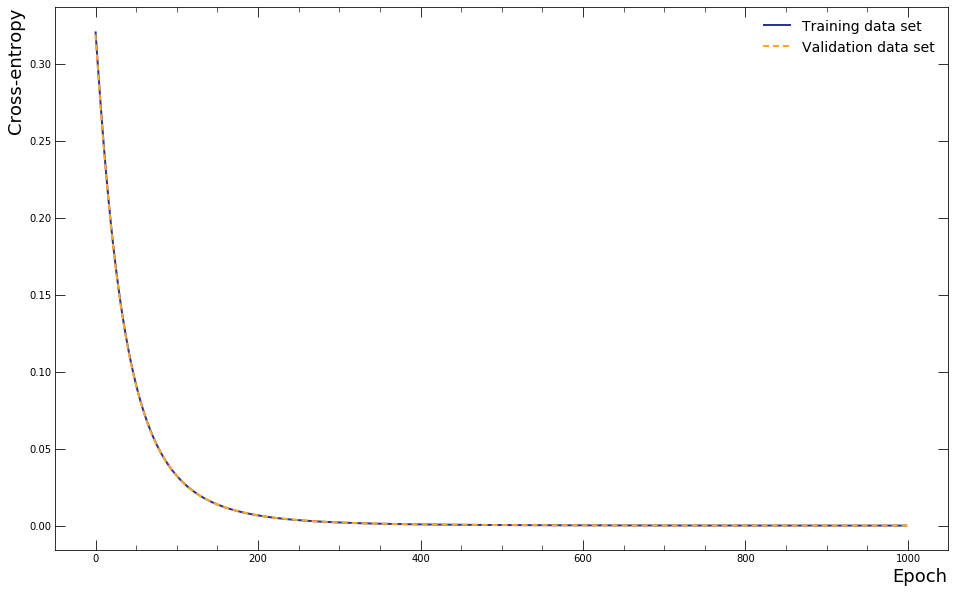

In [137]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

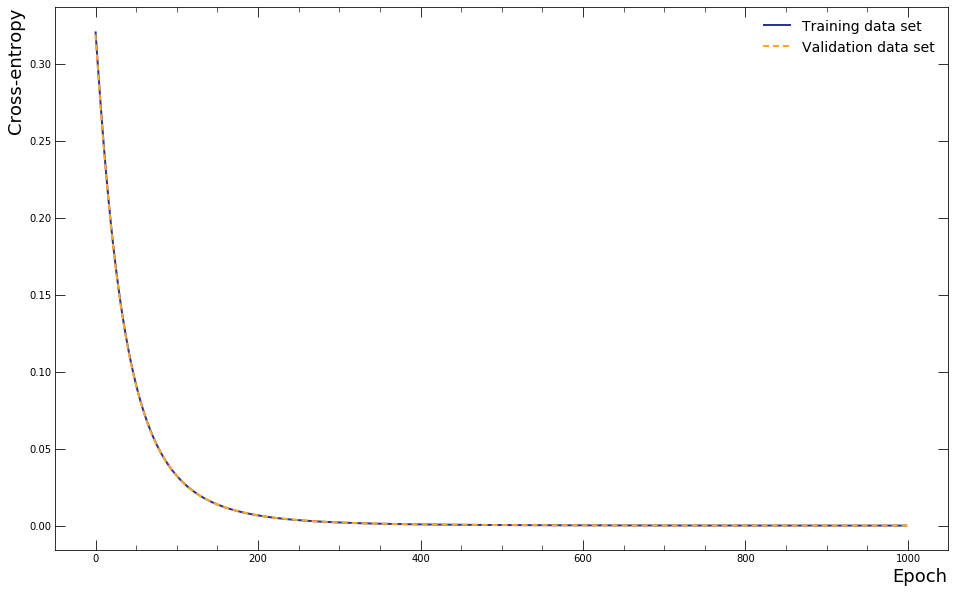

In [138]:
plot_loss(history)

## Training Set

In [139]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_train_new = []
lumi_new = []
lumi = data[str(runs[0])]['lumiid'] 

for l in range(len(x_train)):
    if not 0 in x_train[l]:
        x_train_new.append(x_train[l])
        lumi_new.append(lumi[l])
                
reconstructed = model.predict(np.array(x_train))

error = abs(x_train-reconstructed)/x_train

In [140]:
error_reformat = []
inp = []
outp = []
for i in range(6):
    error_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    for j in range(6):
        error_reformat[j].append(error[i][j])
        outp[j].append(reconstructed[i][j])
        inp[j].append(x_train_new[i][j])

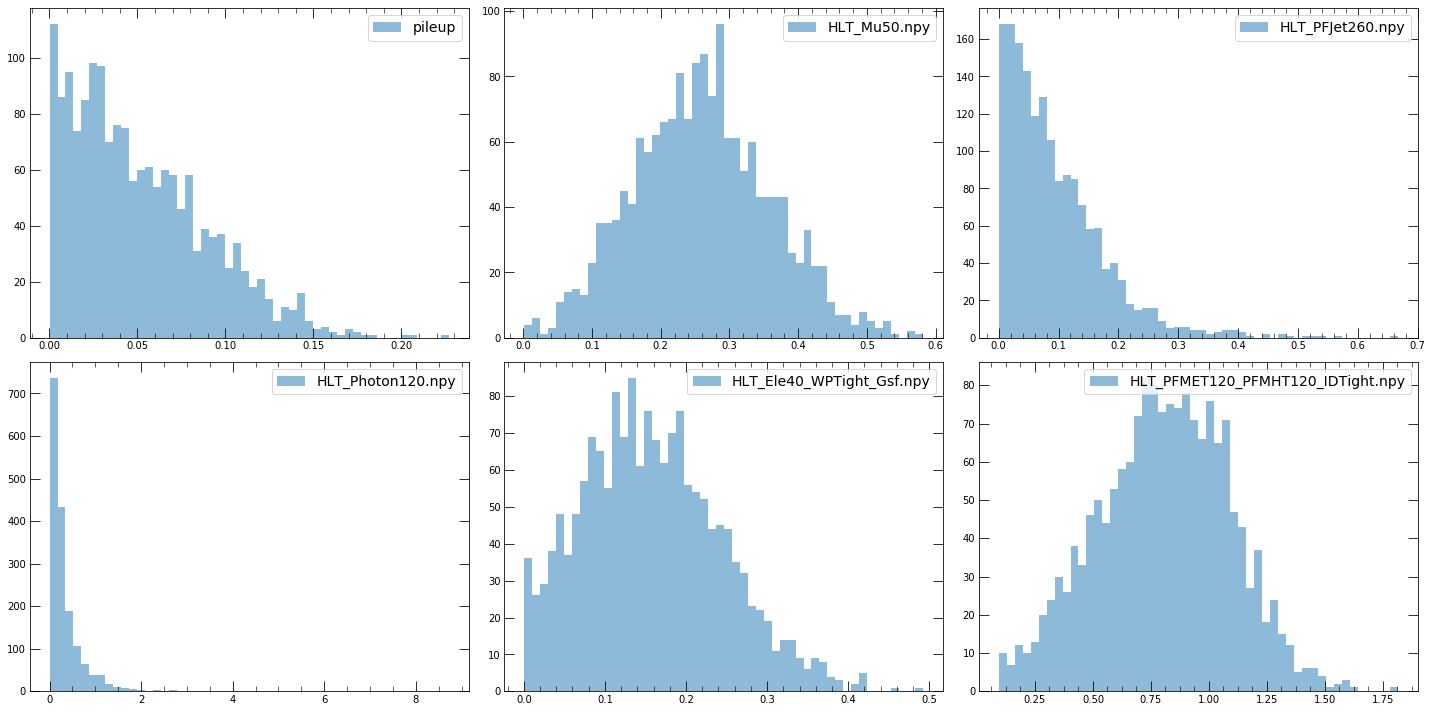

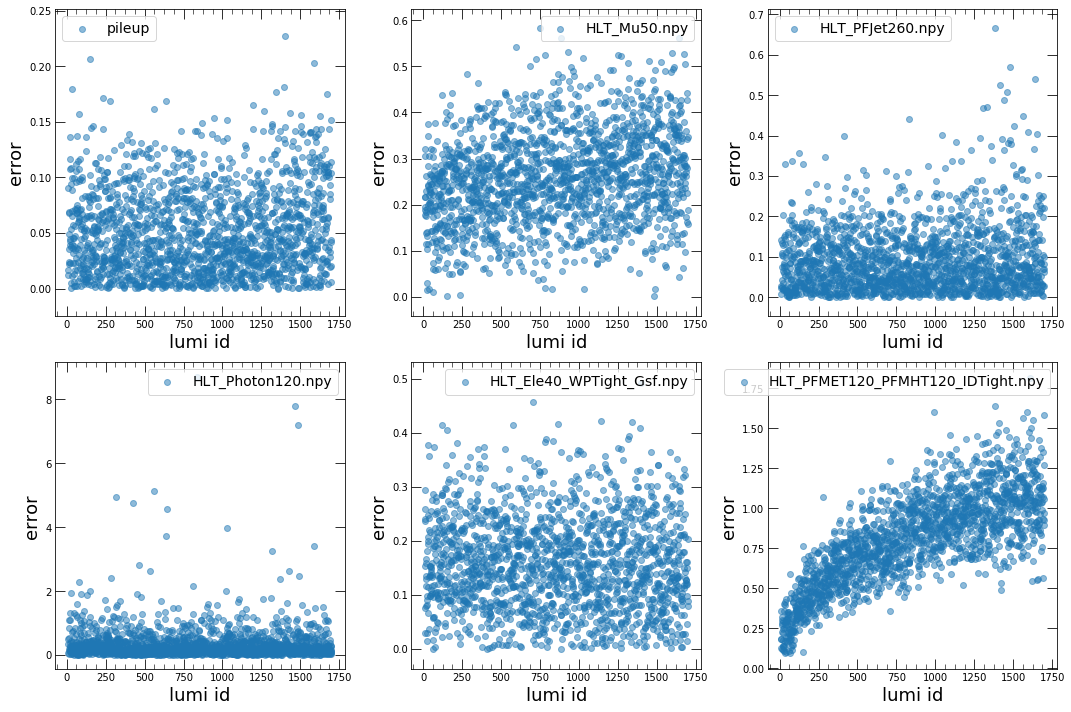

In [141]:
labels = ['pileup'] + data['HLT']
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
plt.tight_layout()

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
plt.tight_layout()
plt.show()

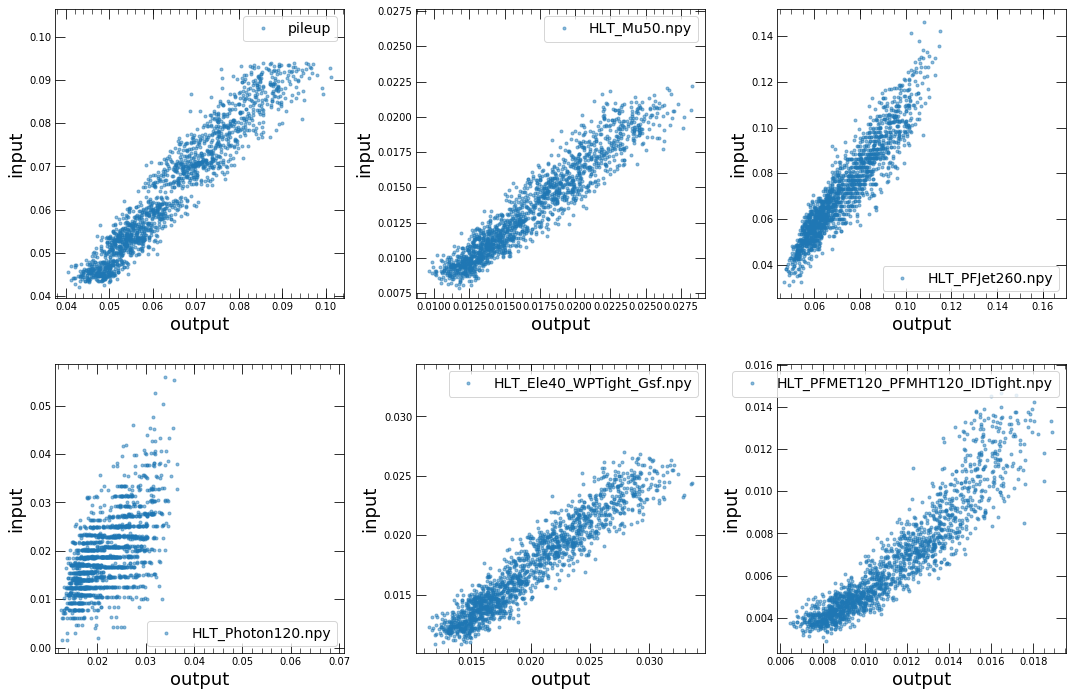

In [142]:
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend() 
    
    plt.axis('square')

plt.tight_layout()
plt.show()

## Test Data

In [143]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = abs(x_test_new-reconstructed)/x_test_new

In [144]:
error_reformat = []
inp = []
outp = []
for i in range(6):
    error_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    #print(len(error_reformat[0]))
    for j in range(6):
        error_reformat[j].append(error[i][j])
        outp[j].append(reconstructed[i][j])
        inp[j].append(x_test_new[i][j])

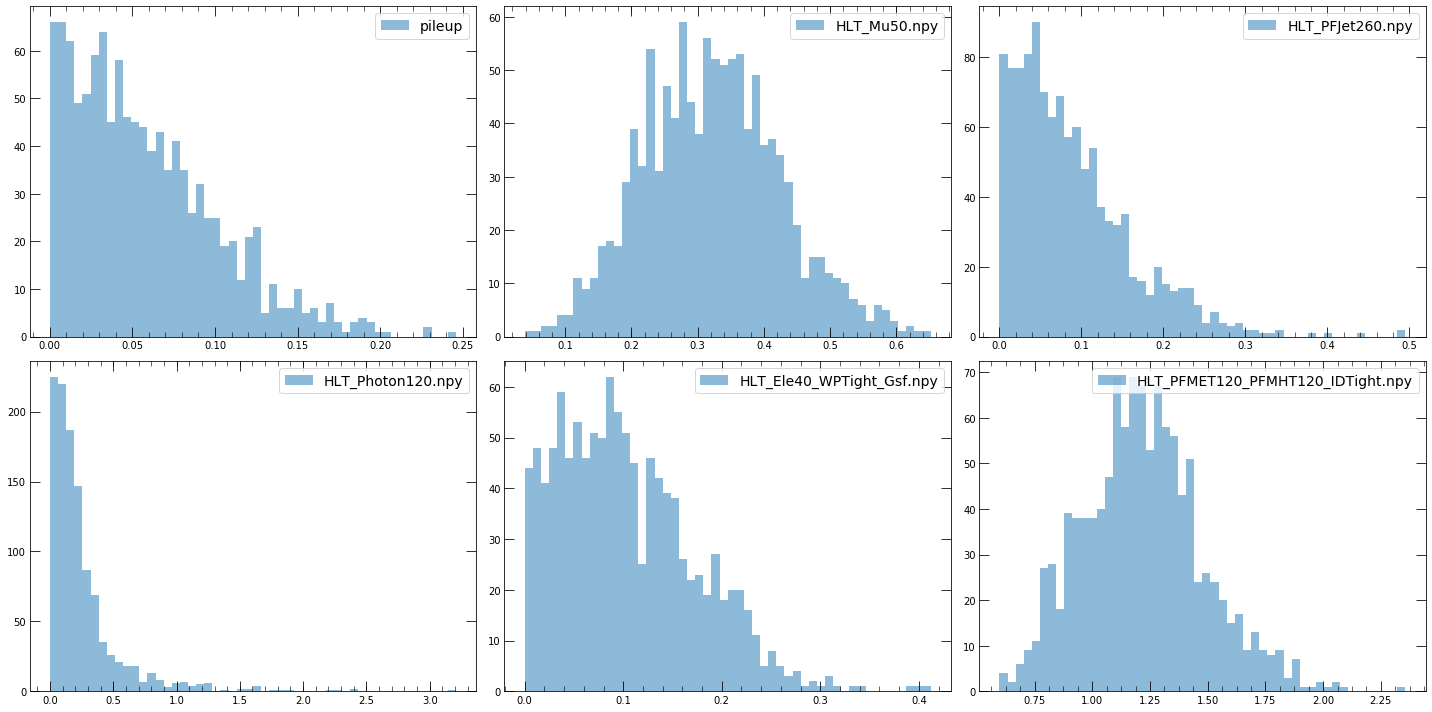

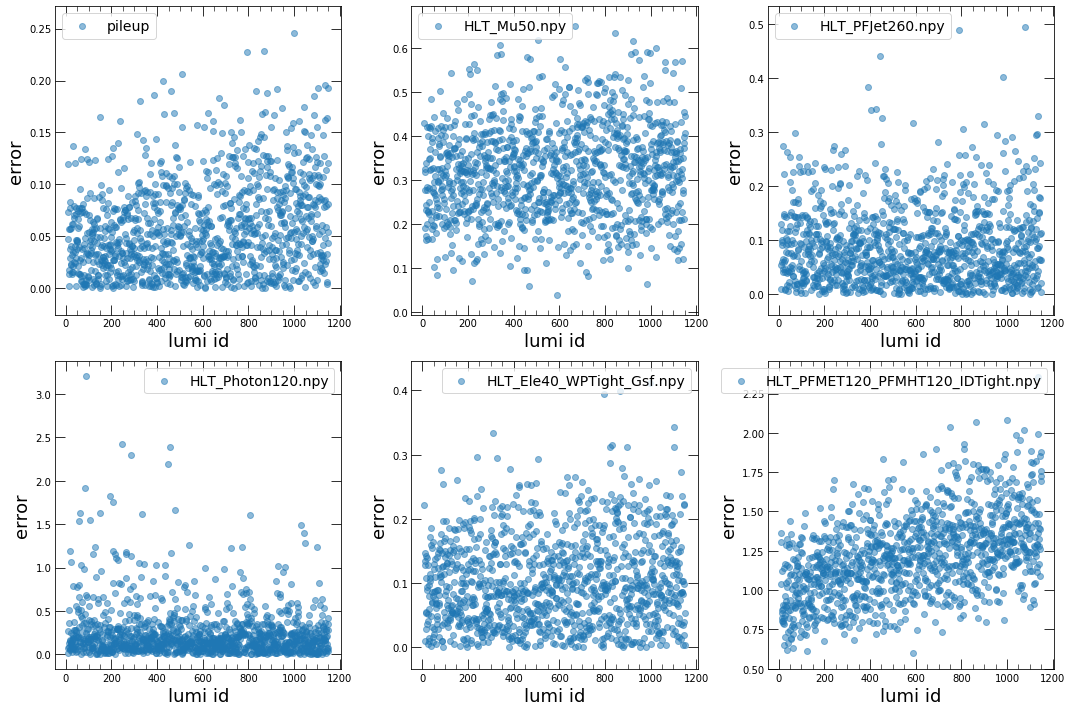

In [145]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
    
plt.tight_layout()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.tight_layout()
plt.show()

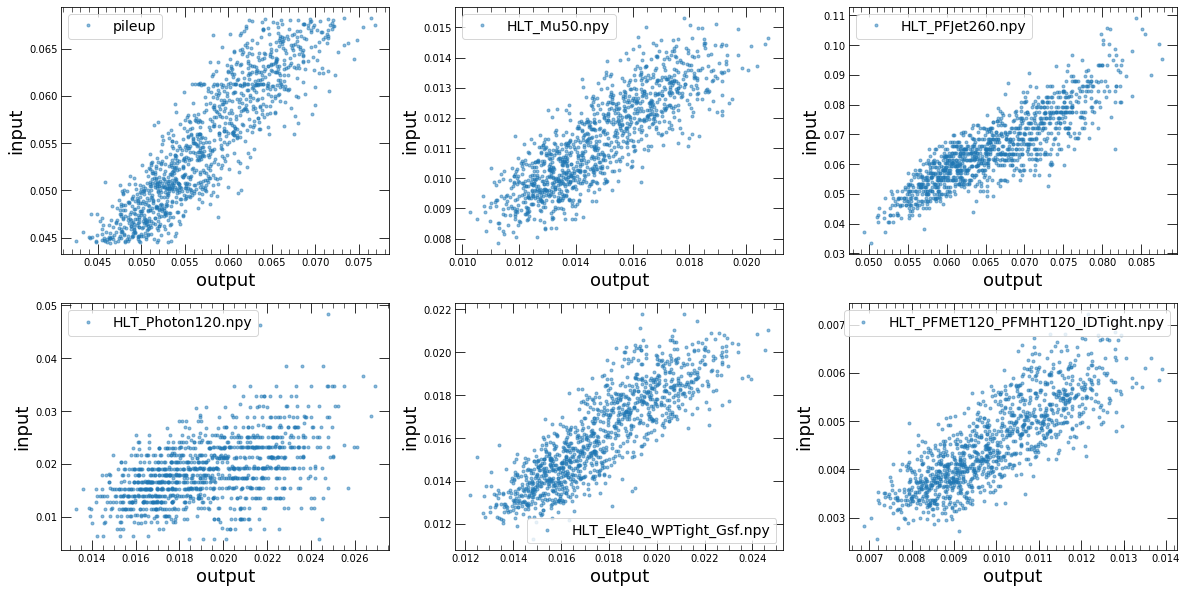

In [146]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

In [147]:
# plt.figure(figsize=[15,10])
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [148]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [149]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [150]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [151]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])
            
        

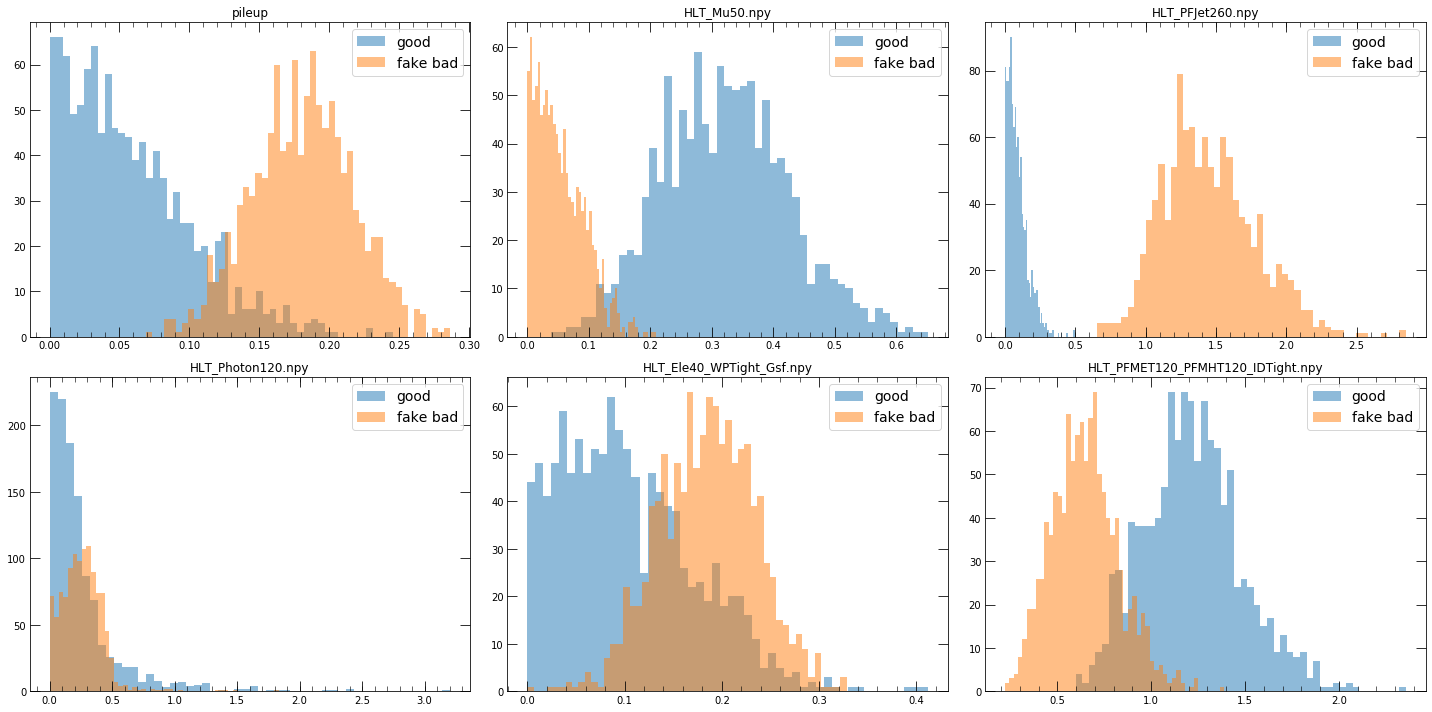

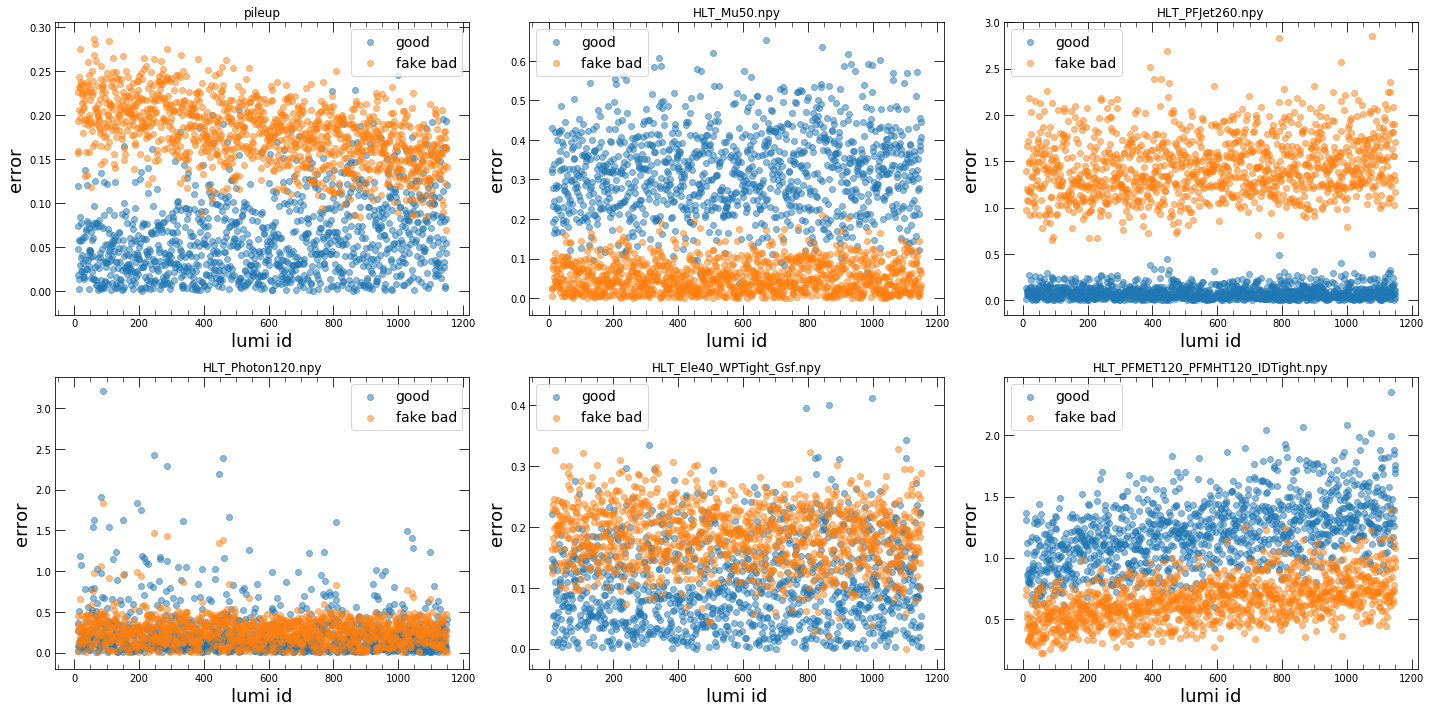

In [152]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi = data[str(runs[2])]['lumiid'] 
#print(len(error_reformat_bad[0]),len(error_reformat[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

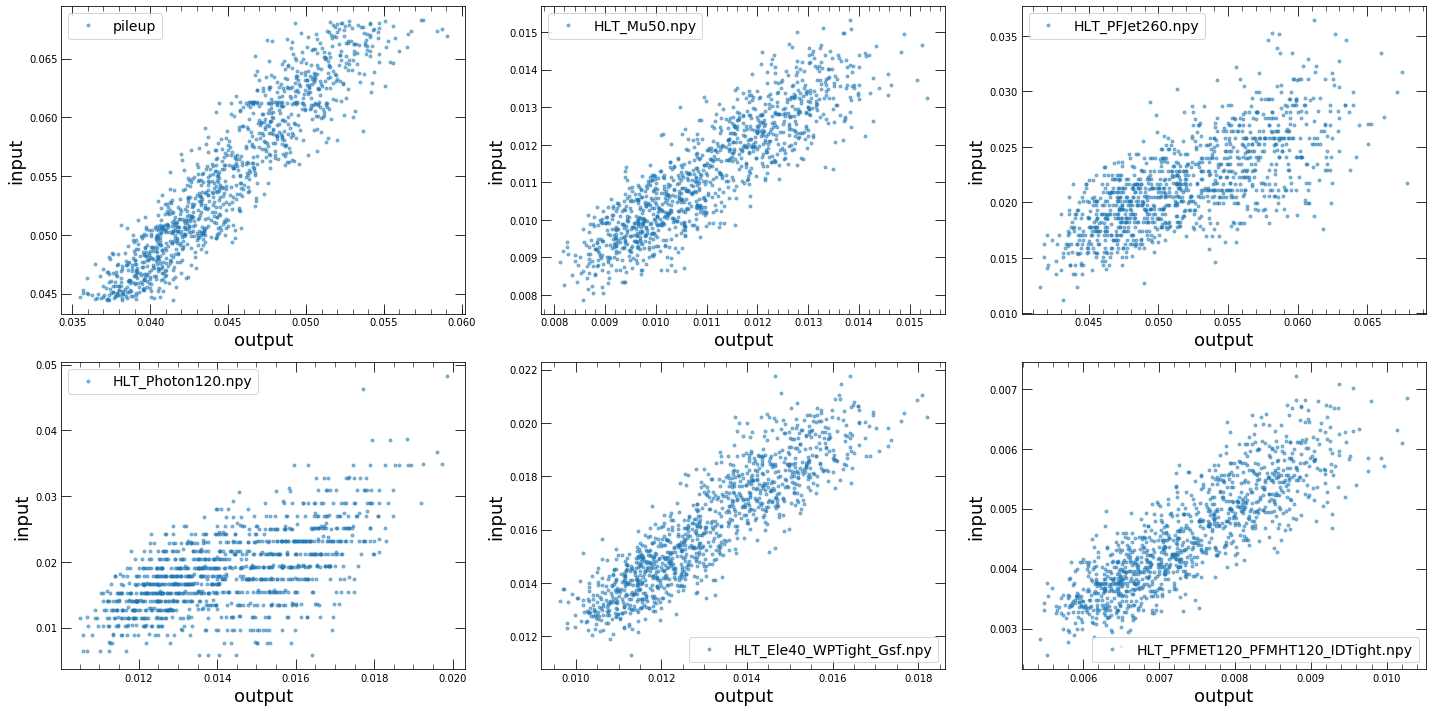

In [153]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    plt.legend()    
plt.tight_layout()
plt.show()

In [154]:
# plt.figure(figsize=[15,10])
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [155]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[15,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,3,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[15,10])
# # for i in range(6):
# #     plt.subplot(2,3,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Fake Bad Data - ALL

In [156]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [157]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [158]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

1129 1129


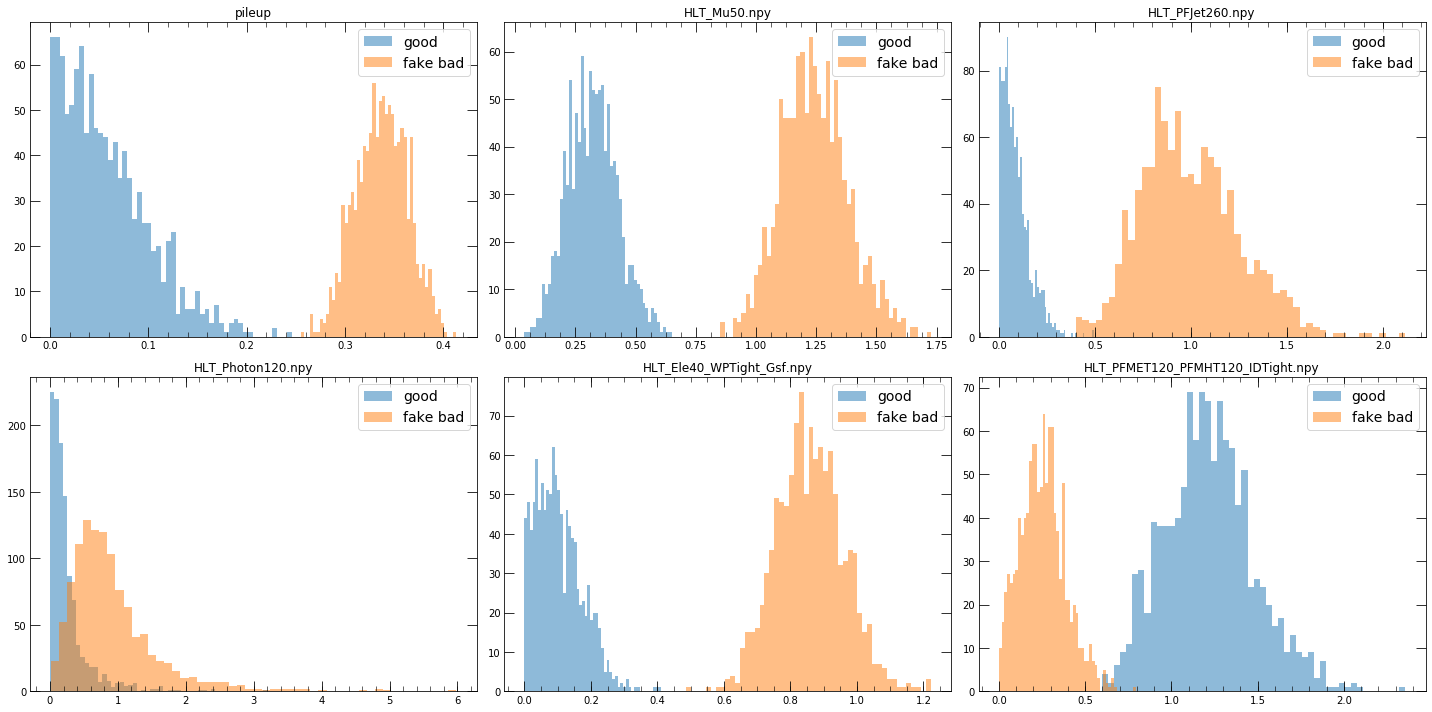

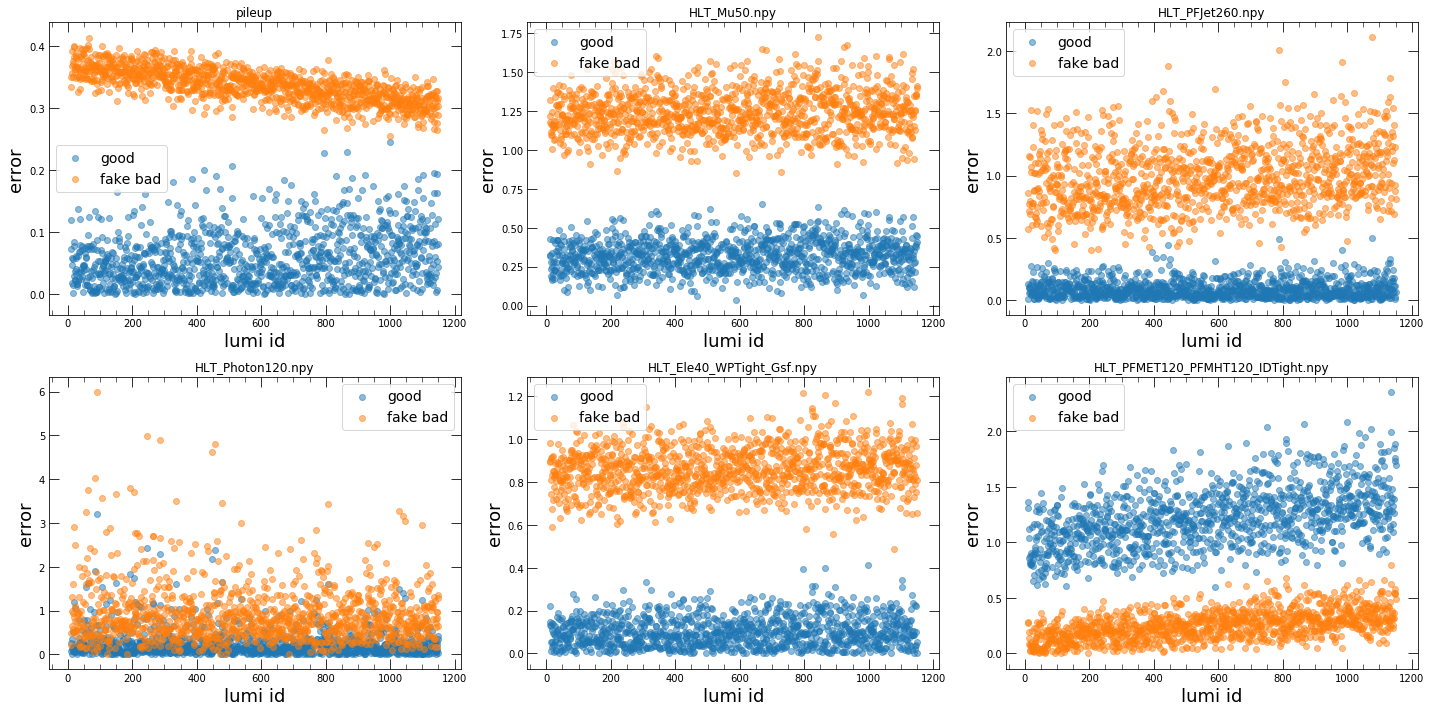

In [159]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
    
plt.show()

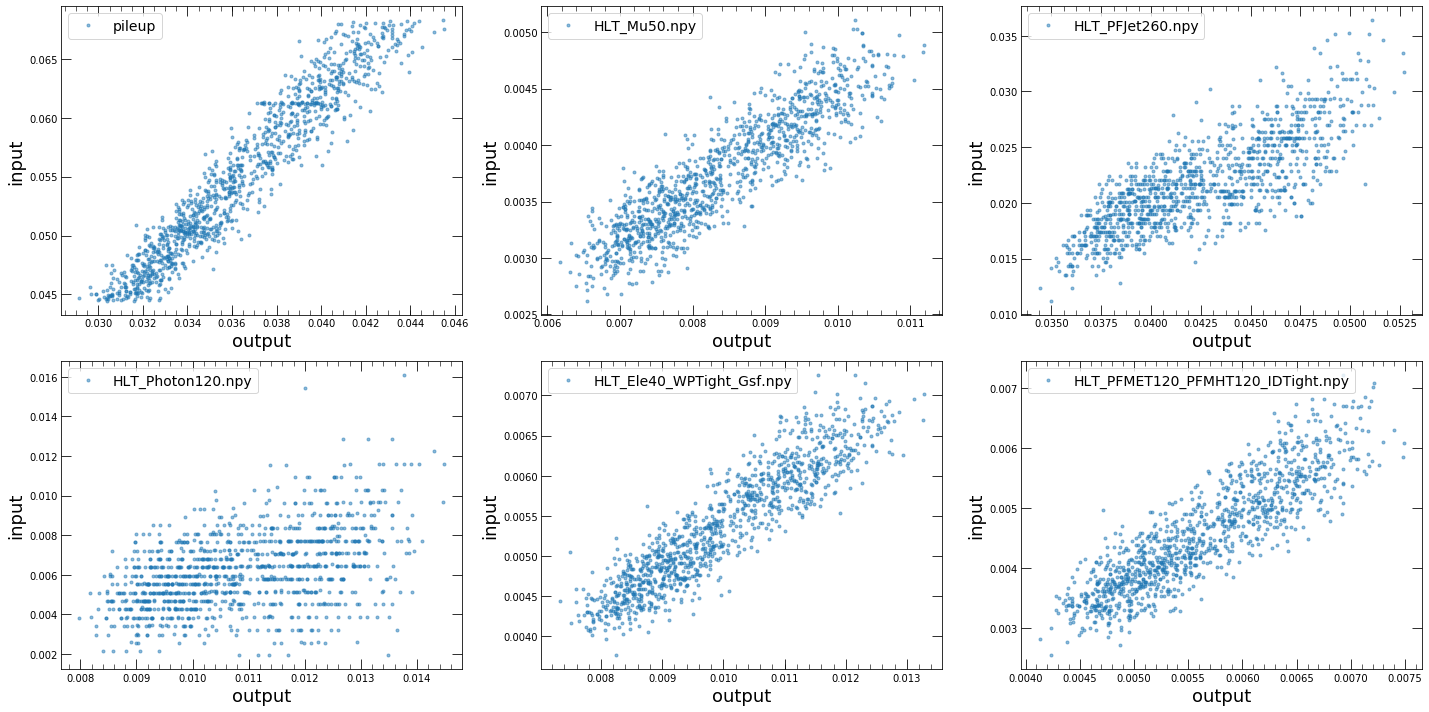

In [160]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.tight_layout()
    
plt.show()

In [161]:
# plt.figure(figsize=[15,10])
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.scatter(lumi,inp_bad[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [162]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[15,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,3,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[15,10])
# # for i in range(6):
# #     plt.subplot(2,3,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Real Bad Data

In [163]:
bad_runs = [301480]

with open('pileupInput_bad.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [164]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [165]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

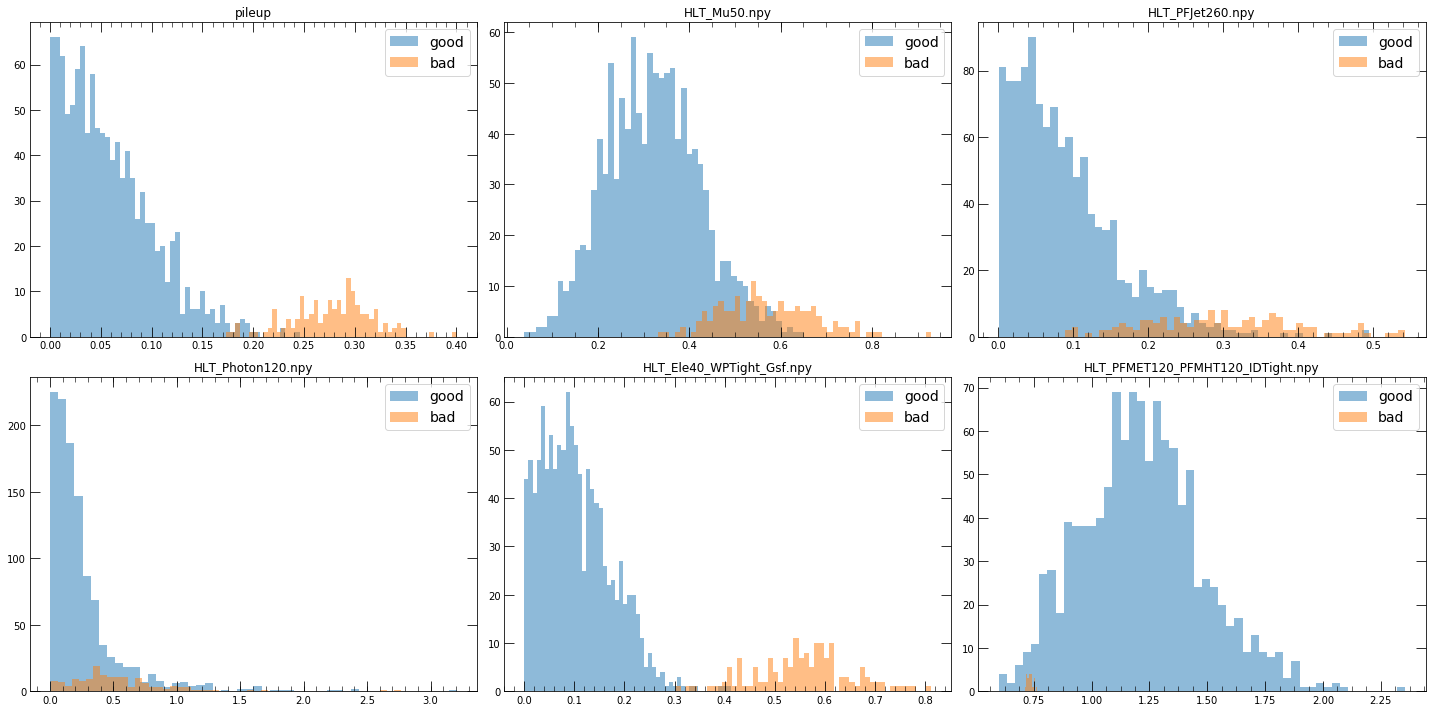

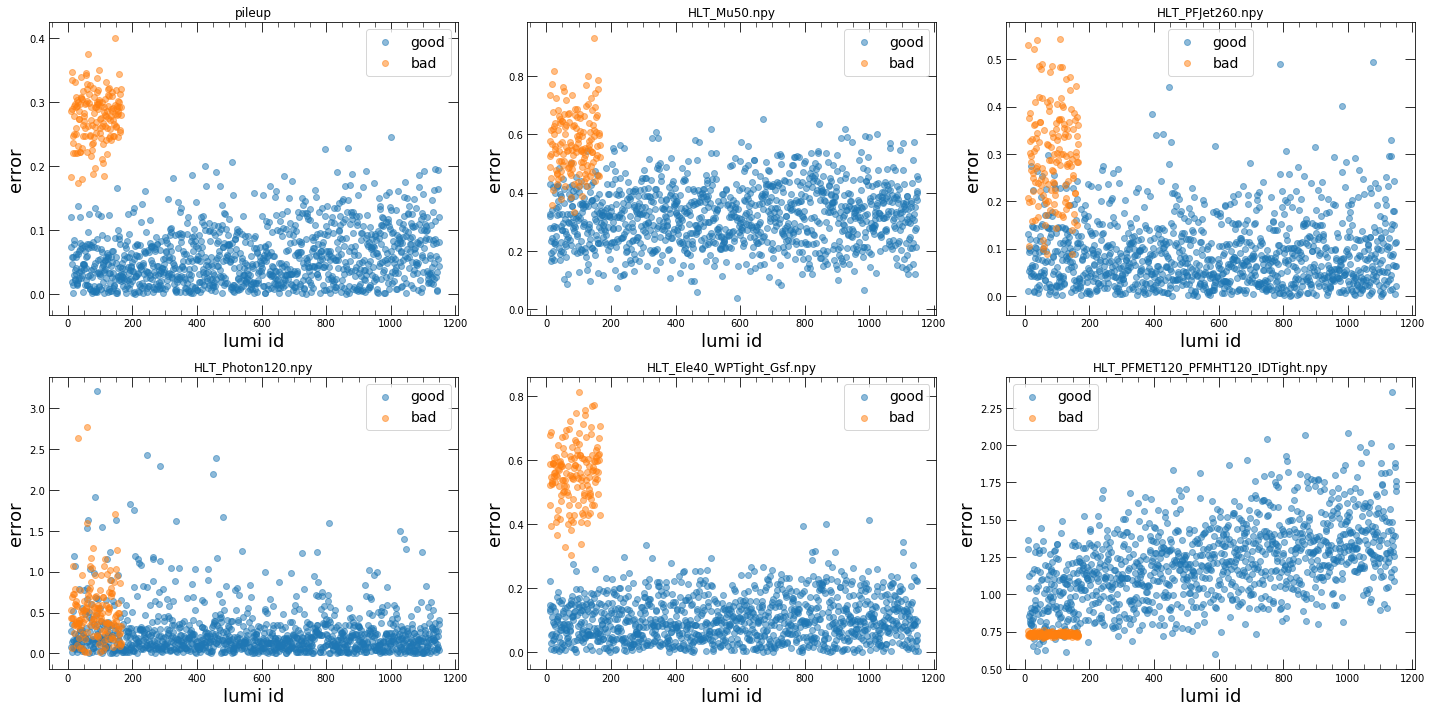

In [166]:
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
#print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

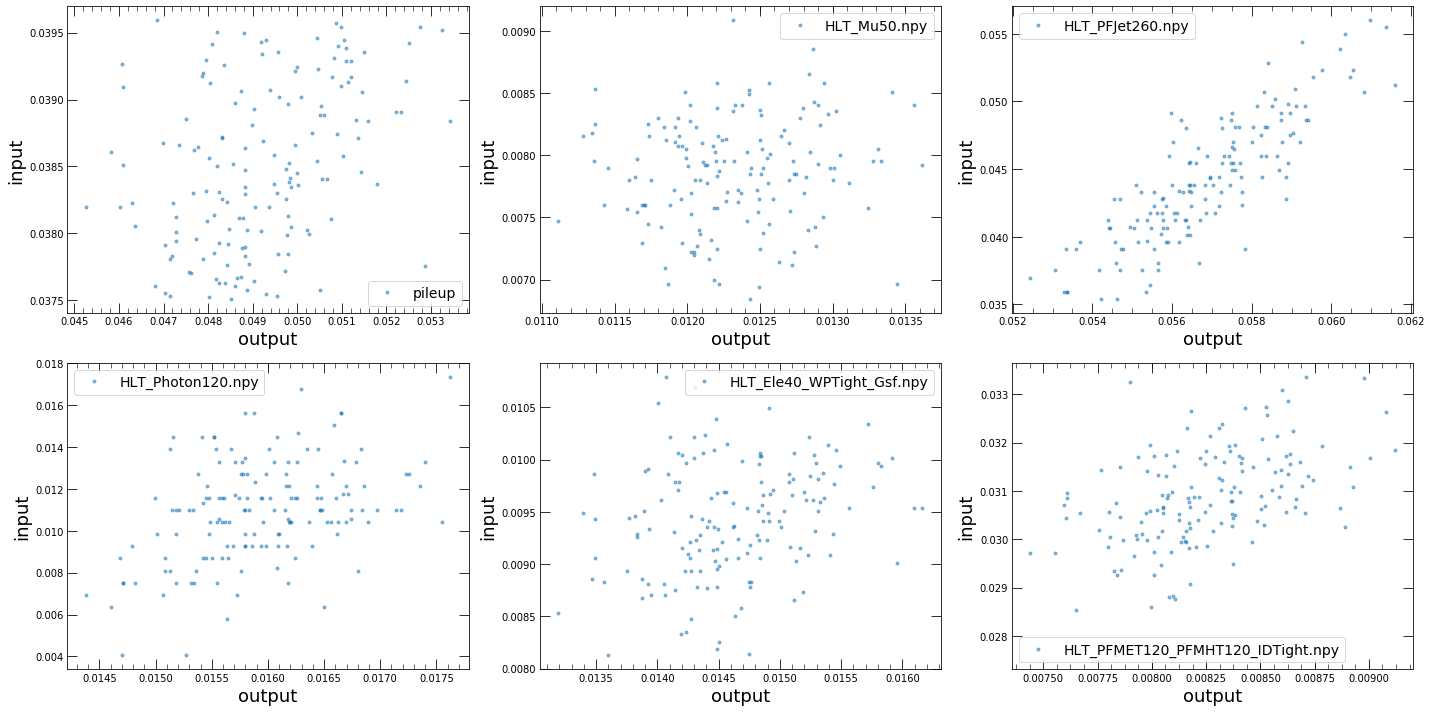

In [167]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()   

plt.tight_layout()
plt.show()

## Real Bad Data

In [168]:
bad_runs = [305588]
x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [169]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [170]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

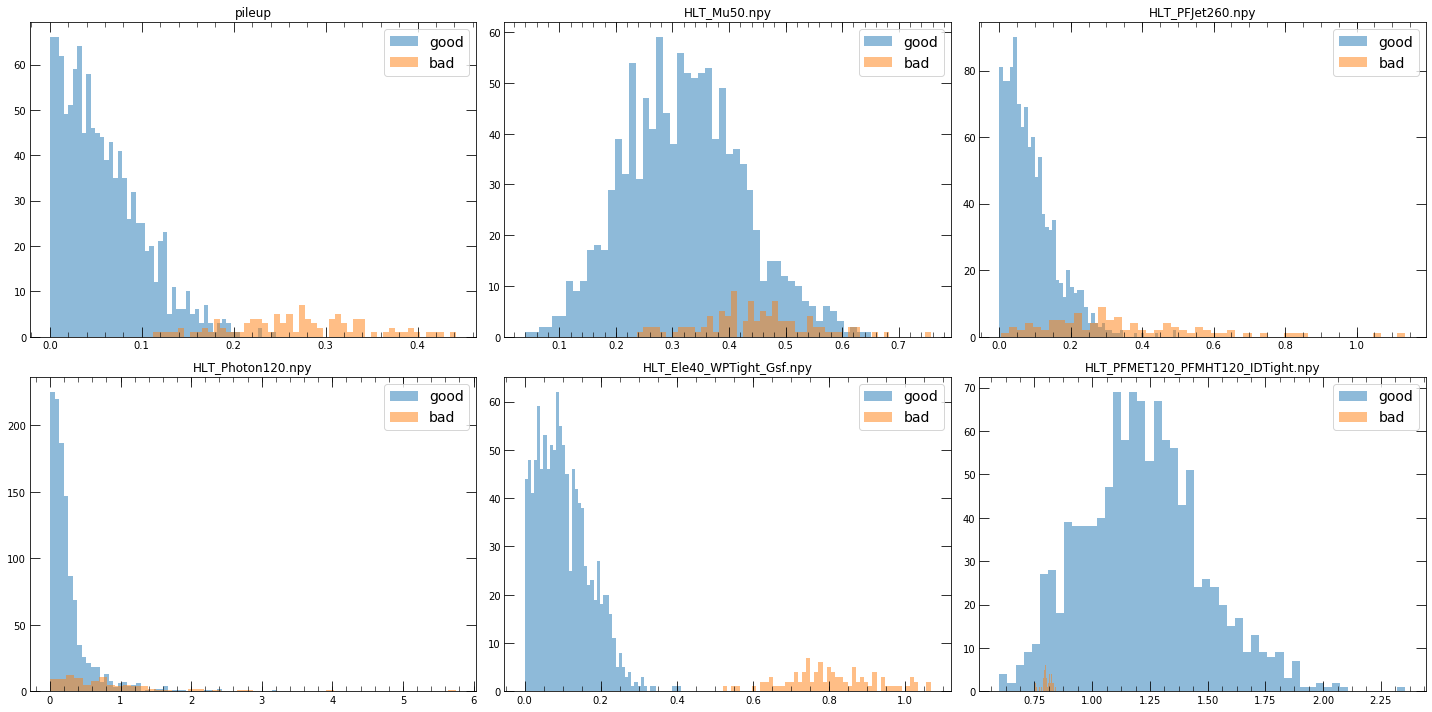

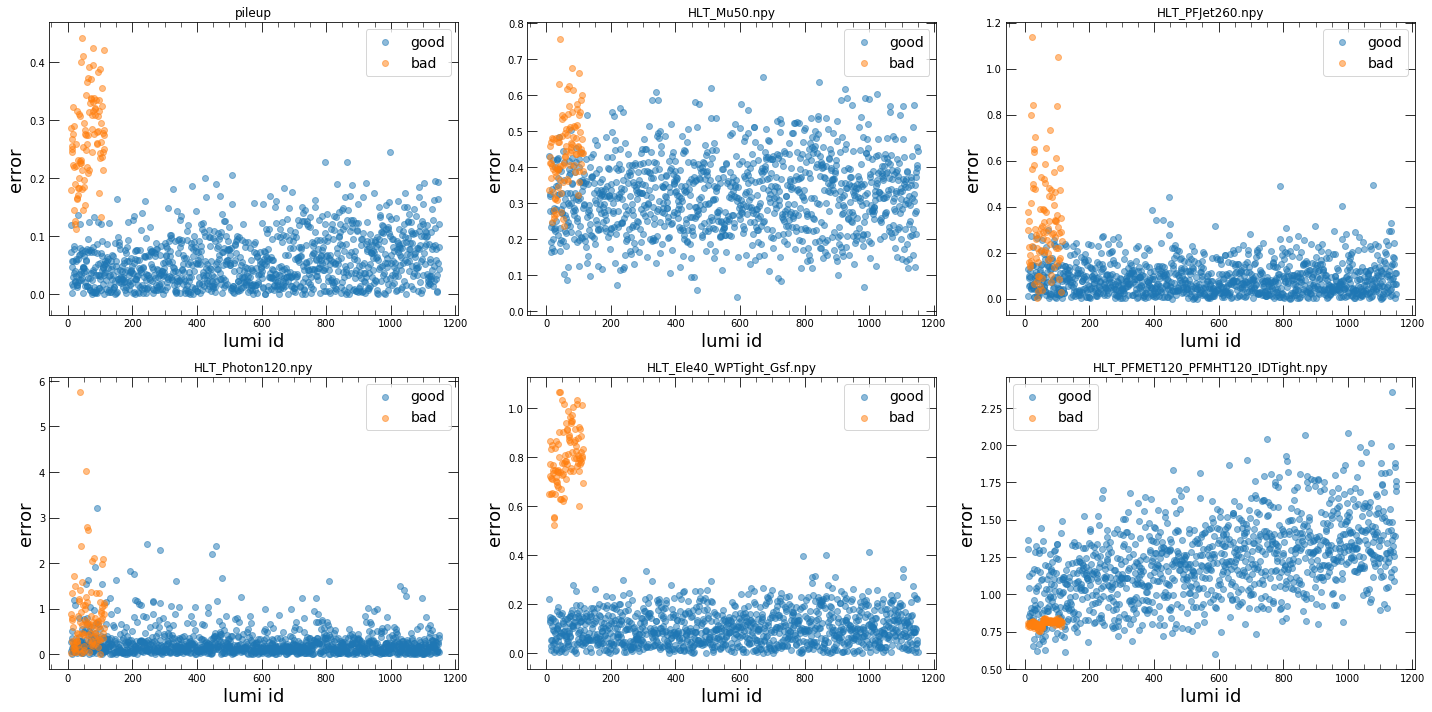

In [171]:
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()
plt.show()

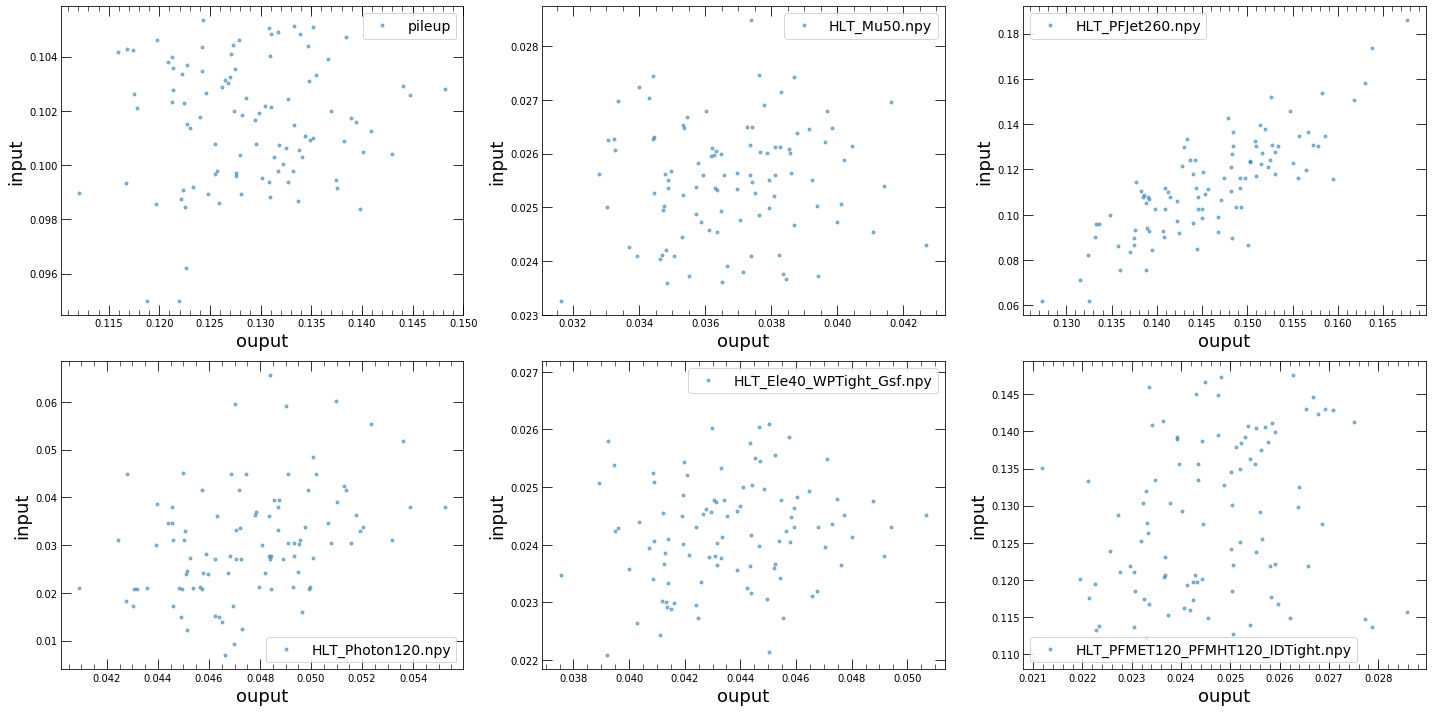

In [172]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('ouput')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    
plt.tight_layout()
plt.show()